In [1]:
# !pip install emcee
# !pip install corner
# !pip install

In [2]:
import pandas as pd
import operator
import numpy as np
import scipy.stats as sps

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

import matplotlib as mpl
%matplotlib inline

import emcee
import pymc3 as pm

from astropy.table import Table
import astropy.io as asio
from astropy.io import fits
import corner

import io
from google.colab import files

/Users/sean/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/sean/anaconda3/lib/python3.6/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/Users/sean/anaconda3/lib/python3.6/s

In [3]:
def nanmask(array):
    mask = (np.isnan(array) == False)
    newarray = array[mask]
    return newarray, mask

def seanscat(x,y):
    xlab = input("What would you like the x label to be?")
    ylab = input("What would you like the y label to be?")
    pointsize = input("What would you like the size of the scatter points to be?")
    plt.scatter(x,y,s=int(pointsize))
    plt.xlim(0.9*min(x),1.1*max(x))
    plt.ylim(0.9*min(y),1.1*max(y))
    plt.grid()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(xlab+" vs. "+ylab)
    plt.show()
    
def reducer(df,keycol,key=np.inf):
    delindex=[]
    for i in range(len(keycol)):
        if keycol[i]!=key:
            delindex.append(i)
    return df.drop(delindex)

def reducer2(df,keycol,key=np.inf):
    delindex=[]
    for i in range(len(keycol)):
        if keycol[i]==key:
            delindex.append(i)
    return df.drop(delindex)

def reducer3(df,keycol):
    delindex=[]
    for i in range(len(keycol)):
        if np.isnan(keycol[i]):
            delindex.append(i)
    return df.drop(delindex)

In [4]:
# from google.colab import drive # if on google colab
# drive.mount("/content/gdrive", force_remount=True)
# path = "/content/gdrive/My Drive/19-20/Thesis/Python and colab code/Summertime/MPAMaster.csv"
# MPAMaster=pd.read_csv(path)

In [5]:
MPAMaster = pd.read_csv("MPAMaster.csv") # if in jupy

In [6]:
# MPAMaster = MPAMaster.drop(columns = ["Unnamed: 0"])
MPAMaster["Inclination"] = (180/np.pi)*np.arccos(MPAMaster["expAB_r"])

print(MPAMaster.columns.values)

BDecLabel = "Log(H\u03B1/H\u03B2)"
LCOLabel = "Log(L$_{CO}$)"
MDustLabel = "Log(M$_{Dust}$/M$_*$)"
MH2Label = "Log(M H$_2$/M$_*$)"
StarMassLabel = "Log(M$_{Star}$/M$_*$)"
SFRLabel = "SFR"
GasFracLabel = "GasFrac"

['Unnamed: 0' 'Z' 'Z err' 'H alpha flux' 'H alpha flux error'
 'H beta flux' 'H beta flux error' 'BDec' 'BDec Err' 'objid' 'expAB_r'
 'RA' 'DEC' 'StarMass' 'StarMass P16' 'StarMass P84' 'SFR' 'SFR P16'
 'SFR P84' 'SFR err' 'SFR FLAG' 'SFR ENTROPY' 'GALAXY CLASS' '12+LOG OH'
 '12+LOG OH P16' '12+LOG OH P84' '12+LOG OH err' 'EB-V' 'Inclination']


In [7]:
print(len(MPAMaster))

MPAMaster = reducer3(MPAMaster,np.asarray(MPAMaster["Inclination"])) # removing galaxies with nan at 

print(len(MPAMaster))

MPAMaster = reducer(MPAMaster,np.asarray(MPAMaster["GALAXY CLASS"]),1) # retaining star forming galaxies

print(len(MPAMaster))

MPAMaster.to_csv("MPAMaster.csv")

# print(MPAMaster["Inclination"])

MPAMaster["GALAXY CLASS"]

927552
106092


KeyError: '[ 266  267  915 1125 9245 9259 9358 9359] not found in axis'

# MCMC attempt at fitting a plane

Here is all of the code from the previous notebook, but you need to modify it to fit to a plane

Found here https://dfm.io/posts/fitting-a-plane/ details fitting a 3d plane to data

Let m1 = Starmass slope
Let m2 = SFR slope

Fit the equation z=m1*x+m2*y+b using MCMC

In [9]:

x =  MPAMaster["StarMass"]# set your variables here
y = MPAMaster["SFR"]
z = MPAMaster["MDust_MCMC"]

x,y,z = reducer(pd.df(x,y,z),MPAMaster["GALAXY CLASS"],key=1)

# xerr = (MPAMaster["StarMass P84"]-MPAMaster["StarMass P16"])/2
# yerr = MPAMaster["SFR err"]
# zerr = MPAMaster["Z err"]

stepnum = 10**4 # Set the step number of the mcmc run

nwalkers = 10**4

xlab = StarMassLabel # Set your labels here
ylab = SFRLabel
zlab = MDustLabel

TypeError: reducer() got multiple values for argument 'key'

Take a look at what it looks like

In [ ]:
from mpl_toolkits import mplot3d

fig = plt.figure(num=None, figsize=(4, 4), dpi=200, facecolor='w', edgecolor='k')
ax = plt.axes(projection='3d')
ax.scatter(x,y,z, c=MPAMaster["GALAXY CLASS"],s=.05, linewidth=0.5) #  c=z, cmap='RdBu' <- can add if you want
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
ax.set_zlabel(zlab)

mctitle = xlab+" vs. "+ylab +" MCMC fit with "+str(stepnum)+" steps"
threeplotTitle = xlab+" vs. "+ylab +" vs. "+zlab +" MCMC fit with "+str(stepnum)+" steps"

plt.title(threeplotTitle)

ax.view_init(30, 30)
plt.savefig("3DGasFrac.png",dpi=300)
plt.show()

Looks Pretty neat huh! How about against each other

In [ ]:
def guesser(x,y):
    sm=0
    for i in range(1,len(x)):
        sm+=(y[i]+y[i-1])/(x[i]+x[i-1])
#     print(sm,len(x))
    return sm/len(x)

m1_guess = guesser(x,z) # Set parameters for guesses
m2_guess = guesser(y,z)# 
b_guess = -1.2
logf_guess = 100
print("m1: ",m1_guess)
print("m2: ",m2_guess)

m1_guess = 50
m2_guess = 20

Nobs = len(x)
x_true = x
y_true = y
alpha_true = b_guess
beta_x_true = m1_guess
beta_y_true = m2_guess
eps_true = logf_guess
z_true = alpha_true + beta_x_true*x_true + beta_y_true*y_true
z_obs = z

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter( z_obs,x_true, s=.1, c=MPAMaster["GALAXY CLASS"], marker='o')
# plt.colorbar()
plt.xlabel(zlab)
plt.ylabel(xlab)
plt.grid()
# plt.ylim(-2,3500)
plt.subplot(1,2,2)
plt.scatter(z_obs, y_true, c=MPAMaster["GALAXY CLASS"], s=.1, marker='o')
# plt.colorbar()
plt.xlabel(zlab)
# plt.ylim(-20,3500)
plt.ylabel(ylab)
plt.grid()
plt.colorbar()

plt.savefig("StarmassVsfrVDustmass_duo.png",dpi=300)

plt.show()

Now set up the equation as if it's z = m$_1$*x+m$_2$*y+b

In [ ]:
# Setting up some ranges, parameters, and functions for plotting purposes

burnin = int(0.05*stepnum) # burnin
mctitle = xlab+" vs. "+ylab +" MCMC fit with "+str(stepnum)+" steps"
threeplotTitle = xlab+" vs. "+ylab +" vs. "+zlab +" MCMC fit with "+str(stepnum)+" steps"

def lnprior(p):
    # The parameters are stored as a vector of values, so unpack them
    alpha,betax,betay,eps = p
    # We're using only uniform priors, and only eps has a lower bound
    if eps <= 0:
        return -np.inf
    return 0

def lnlike(p, x, y, z):
    alpha,betax,betay,eps = p
    model = alpha + betax*x + betay*y
    # the likelihood is sum of the lot of normal distributions
    denom = pow(eps,2)
    lp = -0.5*sum(pow((z - model),2)/denom + np.log10(denom) + np.log10(2*np.pi))
    return lp

def lnprob(p, x, y, z):
    lp = lnprior(p)
    if not isfinite(lp):
        return -np.inf
    return lp + lnlike(p, x, y, z)

def isfinite(lp):
    if abs(lp) == np.inf:
        return True
    return False
    
# def colcleaner(col,upbound=np.inf,lowbound=-np.inf):
    
#     for i in range

import scipy.optimize as opt
nll = lambda *args: -lnlike(*args)
result = opt.minimize(nll, [alpha_true, beta_x_true, beta_y_true, eps_true],args=(x_true, y_true, z_obs))
print (result['x'])

'''

m_true = np.array([m1_guess, m2_guess])
b_true = b_guess
X = np.empty((N, 3))
X[:, 0] = x
X[:, 1] = y
X[:, 2] = z

nsteps = stepnum
burnin = 0.05*nsteps

sigmax_2 = xerr**2
sigmay_2 = yerr**2
sigmaz_2 = zerr**2 # standard dev's here

S = np.zeros((N, 3, 3))
for n in range(N):
    S[n][0][0] = sigmax_2[n]
    S[n][1][1] = sigmay_2[n]
    S[n][2][2] = sigmaz_2[n]

# print(S) # S is good now.   '''

In [ ]:
ndim=4
Nwalker,Ndim = nwalkers,4 # set walkers here
stepnum = 10**4 # set stepnumber here
p0 = [result['x']+1.e-4*np.random.randn(Ndim) for i in range(Nwalker)]

sampler = emcee.EnsembleSampler(Nwalker,Ndim,lnprob,
                                args=(x_true,y_true,z_obs))
pos,prob,state = sampler.run_mcmc(p0, stepnum+burnin,progress=True)
af = sampler.acceptance_fraction
print("Mean acceptance fraction:", np.mean(af))
# take only values after the chain has converged
realsamples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

In [ ]:
res=plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)

plt.show()

In [ ]:
# sampler.reset()
# pos,prob,state = sampler.run_mcmc(pos, 1000)

In [15]:
m_alpha,m_betax,m_betay,m_eps = np.median(sampler.flatchain, axis=0)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x_true, z_obs-m_alpha-m_betay*y_true, c='orange',s=1)
plt.xlabel(xlab)
plt.ylabel(zlab+' - \u03B1 - \u03B2$_y$'+ylab)
# Now plot the model
xx = np.array([x_true.min(), x_true.max()])
plt.plot(xx, xx*m_betax)
plt.plot(xx, xx*m_betax + m_eps, '--', color='k')
plt.plot(xx, xx*m_betax - m_eps, '--', color='k')
plt.grid()

plt.show()
plt.figure(figsize=(12,6))

plt.subplot(1,2,2)
plt.scatter(y_true, z_obs-m_alpha-m_betax*x_true, c='blue',s=1)
plt.xlabel(ylab)
plt.ylabel(zlab+' - \u03B1 - \u03B2$_x$ *'+xlab)
yy = np.array([y_true.min(), y_true.max()])
plt.plot(yy, yy*m_betay)
plt.plot(yy, yy*m_betay + m_eps, '--', color='k')
plt.plot(yy, yy*m_betay - m_eps, '--', color='k')
plt.grid()

plt.show()

NameError: name 'sampler' is not defined

In [ ]:
corner.corner(sampler.flatchain, labels=["\u03B2$_x$", "\u03B2$_y$", "\u03B1", "$\ln\lambda$"],
              truths=[alpha_true, beta_x_true, beta_y_true, eps_true])
plt.show()

## Dividing things up by inclination

In [11]:
upperPerc = 84
lowerPerc = 100-upperPerc
upperVal = np.percentile(MPAMaster["Inclination"],upperPerc)
lowerVal = np.percentile(MPAMaster["Inclination"],lowerPerc) # find where inclination is and get it in the MPA Master
print(str(upperPerc)+"th percentile of inclination:", upperVal)
print(str(lowerPerc)+"th percentile of inclination:", lowerVal)

hightmpStarmass, hightmpSFR, hightmpMH2, hightmpLCO, hightmpMDust, hightmpGasFrac, lowtmpStarmass, lowtmpSFR, lowtmpMH2, lowtmpLCO, lowtmpMDust, lowtmpGasFrac = (np.array(0) for i in range(12))

print(hightmpGasFrac)

for i in range(len(MPAMaster["Inclination"])):
    iterator = np.array(MPAMaster["NUMID"])[i]
    if (MPAMaster["Inclination"])[iterator]>=upperVal:
        
        hightmpStarmass = np.append(hightmpStarmass,MPAMaster["StarMass"][iterator])
        hightmpSFR = np.append(hightmpSFR,MPAMaster["SFR"][iterator])
        hightmpMH2 = np.append(hightmpMH2,MPAMaster["MH2_MCMC"][iterator])
        hightmpLCO = np.append(hightmpLCO,MPAMaster["LCO_MCMC"][iterator])
        hightmpMDust = np.append(hightmpMDust,MPAMaster["MDust_MCMC"][iterator])
        hightmpGasFrac = np.append(hightmpGasFrac,MPAMaster["GasFrac"][iterator])
        
    elif (MPAMaster["Inclination"])[iterator]<=lowerVal:
        
        lowtmpStarmass = np.append(lowtmpStarmass,MPAMaster["StarMass"][iterator])
        lowtmpSFR = np.append(lowtmpSFR,MPAMaster["SFR"][iterator])
        lowtmpMH2 = np.append(lowtmpMH2,MPAMaster["MH2_MCMC"][iterator])
        lowtmpLCO = np.append(lowtmpLCO,MPAMaster["LCO_MCMC"][iterator])
        lowtmpMDust = np.append(lowtmpMDust,MPAMaster["MDust_MCMC"][iterator])
        lowtmpGasFrac = np.append(lowtmpGasFrac,MPAMaster["GasFrac"][iterator])
print(hightmpGasFrac)
# print((MPAMaster[""][2]),(MPAMaster[""][2]))

hightmpStarmass= hightmpStarmass[1:]
hightmpSFR= hightmpSFR[1:]
hightmpMH2= hightmpMH2[1:]
hightmpLCO= hightmpLCO[1:]
hightmpMDust= hightmpMDust[1:]
hightmpGasFrac= hightmpGasFrac[1:]
lowtmpStarmass= lowtmpStarmass[1:]
lowtmpSFR= lowtmpSFR[1:]
lowtmpMH2= lowtmpMH2[1:]
lowtmpLCO= lowtmpLCO[1:]
lowtmpMDust= lowtmpMDust[1:]
lowtmpGasFrac= lowtmpGasFrac[1:]

print(hightmpGasFrac)

84th percentile of inclination: 71.09488337332449
16th percentile of inclination: 34.94600106156095
0
[ 0.         -0.60961265 -0.58482552 ... -1.50102793 -1.38011397
 -1.34097921]
[-0.60961265 -0.58482552 -1.32403887 ... -1.50102793 -1.38011397
 -1.34097921]


### Higher inclination values

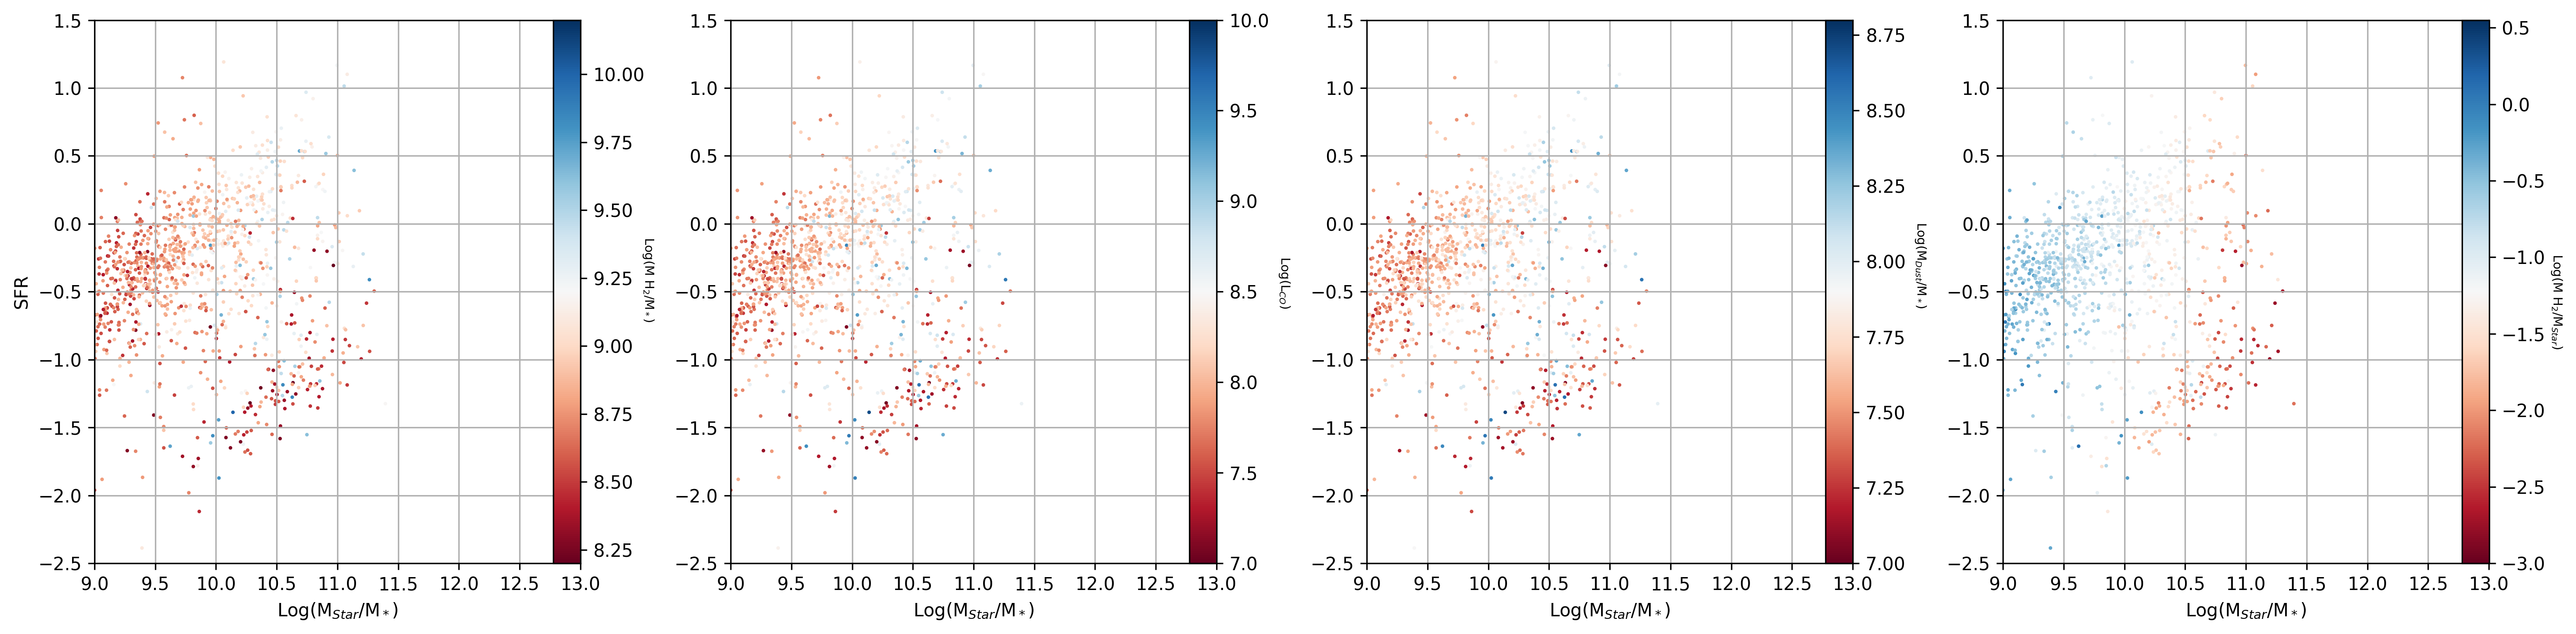

In [12]:
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = figure(num=None, figsize=(20,5), dpi=300, facecolor='w', edgecolor='k')

ylolim = -2.5
yhighlim=1.5

plt.subplot(1, 4, 1)

plt.scatter(hightmpStarmass,hightmpSFR,c=(hightmpMH2),s=1,cmap = "RdBu")
plt.grid()
plt.xlabel(StarMassLabel)
plt.axis("tight")
plt.ylabel(SFRLabel)
plt.colorbar(pad=-0.05,)
plt.clim(vmin=8.2,vmax=10.2)

plt.text(13.5,-.7, MH2Label, rotation = -90,size="x-small")
plt.xlim(9,13)
plt.tight_layout()
plt.ylim(ylolim,yhighlim)
plt.subplot(1, 4, 2)

plt.scatter(hightmpStarmass,hightmpSFR,c=hightmpLCO,s=1,cmap="RdBu")
plt.grid()
plt.xlabel(StarMassLabel)
# plt.ylabel(SFRLabel)
plt.axis("tight")
plt.colorbar(pad=-0.05,)
plt.text(13.5,-0.6, LCOLabel, rotation = -90,size="x-small")
plt.xlim(9,13)
plt.clim(vmin=7,vmax=10)
plt.tight_layout()
plt.ylim(ylolim,yhighlim)
plt.subplot(1, 4, 3)

plt.scatter(hightmpStarmass,hightmpSFR,c=hightmpMDust,s=1,cmap="RdBu") # colorize this by inclination!!
plt.grid()
plt.xlabel(StarMassLabel)
# plt.ylabel(SFRLabel)
plt.axis("tight")
plt.colorbar(pad=-0.05,)
plt.text(13.5,-0.6, MDustLabel, rotation = -90,size="x-small")
plt.xlim(9,13)
plt.clim(vmin=7,vmax=8.8)
plt.tight_layout()
plt.ylim(ylolim,yhighlim)
plt.subplot(1, 4, 4)

plt.scatter(hightmpStarmass,hightmpSFR,c=hightmpGasFrac,s=1,cmap="RdBu") # colorize this by inclination!!
plt.grid()
plt.xlabel(StarMassLabel)
# plt.ylabel(SFRLabel)
plt.axis("tight")
plt.colorbar(pad=-0.05,)
plt.text(13.5,-.9, "Log(M H$_2$/M$_{Star}$)", rotation = -90,size="x-small")
plt.xlim(9,13)
plt.clim(vmin=-3,vmax=0.55)
# plt.clim(min(hightmpGasFrac),max(hightmpGasFrac))

plt.tight_layout()
plt.ylim(ylolim,yhighlim)

plt.savefig("HighInclinationxColdComp.png",dpi=300)

plt.show()

### Lower inclination values

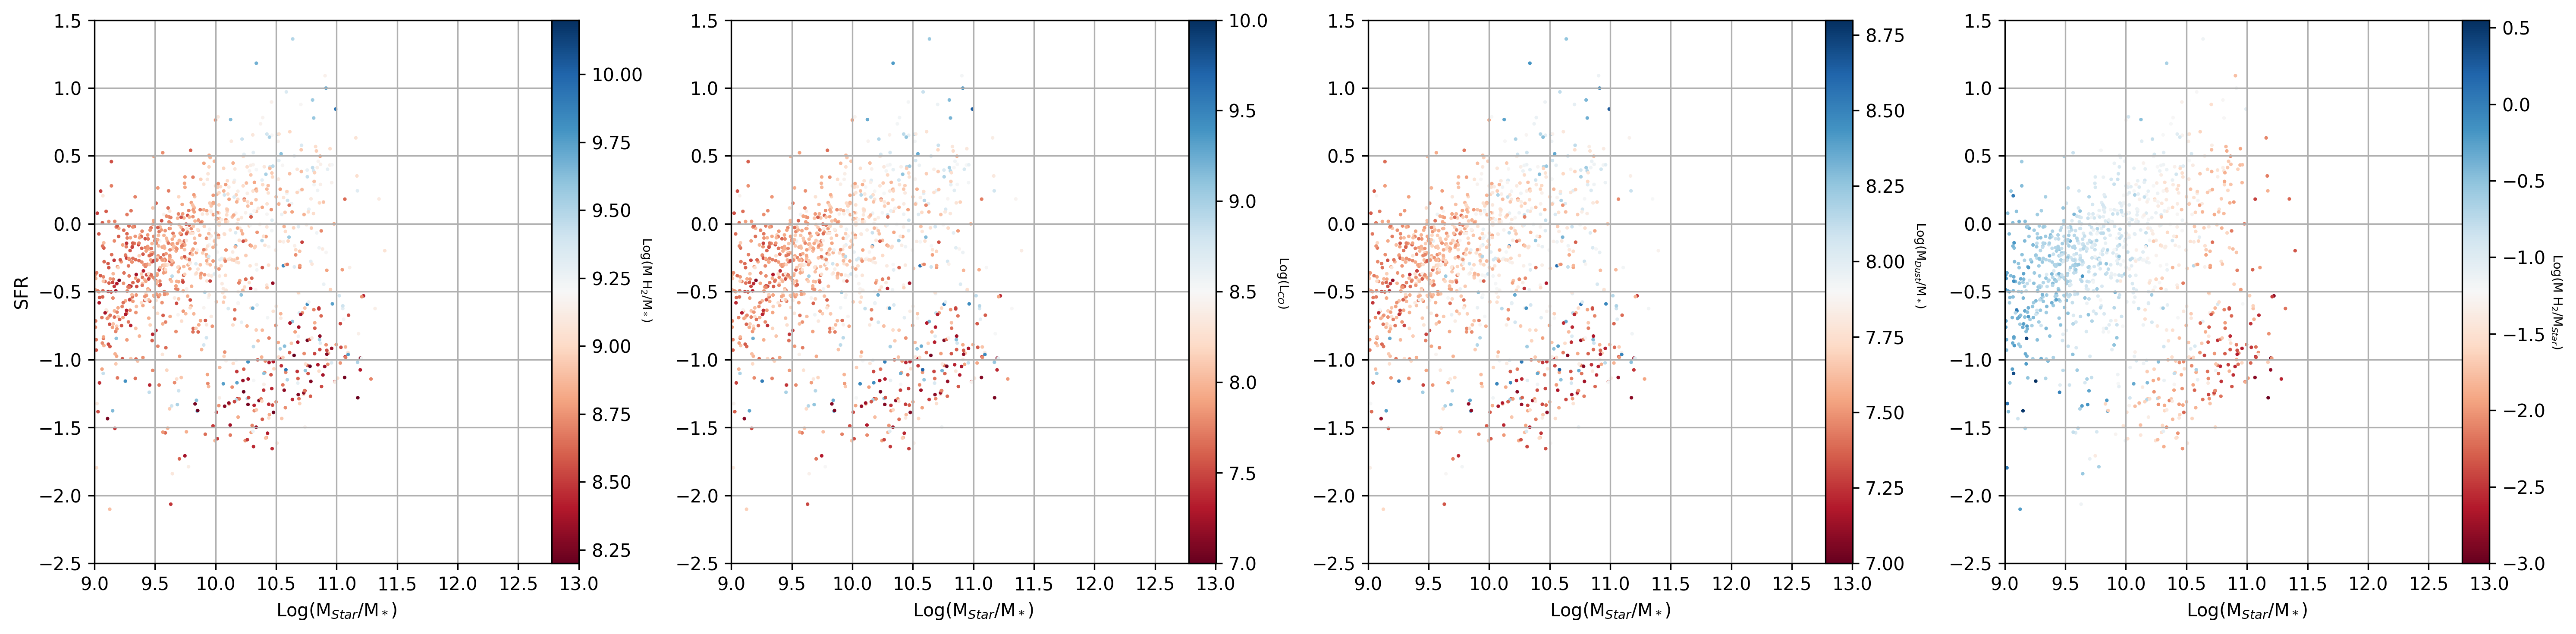

In [13]:
figure(num=None, figsize=(20, 5), dpi=300, facecolor='w', edgecolor='k')

plt.subplot(1, 4, 1)

plt.scatter(lowtmpStarmass,lowtmpSFR,c=(lowtmpMH2),s=1,cmap = "RdBu")
plt.grid()
plt.xlabel(StarMassLabel)
plt.axis("tight")
plt.ylabel(SFRLabel)
plt.colorbar(pad=-0.05,)
plt.clim(vmin=8.2,vmax=10.2)
plt.text(13.5,-.7, MH2Label, rotation = -90,size="x-small")
plt.xlim(9,13)
plt.ylim(ylolim,yhighlim)

plt.subplot(1, 4, 2)

plt.scatter(lowtmpStarmass,lowtmpSFR,c=lowtmpLCO,s=1,cmap="RdBu")
plt.grid()
plt.xlabel(StarMassLabel)
# plt.ylabel(SFRLabel)
plt.axis("tight")
plt.colorbar(pad=-0.05,)
plt.text(13.5,-0.6, LCOLabel, rotation = -90,size="x-small")
plt.xlim(9,13)
plt.ylim(ylolim,yhighlim)
plt.clim(vmin=7,vmax=10)

plt.subplot(1, 4, 3)

plt.scatter(lowtmpStarmass,lowtmpSFR,c=lowtmpMDust,s=1,cmap="RdBu") 
plt.grid()
plt.xlabel(StarMassLabel)
# plt.ylabel(SFRLabel)
plt.axis("tight")
plt.colorbar(pad=-0.05,)
plt.text(13.5,-0.6, MDustLabel, rotation = -90,size="x-small")
plt.xlim(9,13)
plt.clim(vmin=7,vmax=8.8)
plt.ylim(ylolim,yhighlim)

plt.subplot(1, 4, 4)

plt.scatter(lowtmpStarmass,lowtmpSFR,c=lowtmpGasFrac,s=1,cmap="RdBu")
plt.grid()
plt.xlabel(StarMassLabel)
# plt.ylabel(SFRLabel)
plt.axis("tight")
plt.colorbar(pad=-0.05,)
plt.clim(vmin=-3,vmax=0.55)
plt.text(13.5,-.9, "Log(M H$_2$/M$_{Star}$)", rotation = -90,size="x-small")
plt.xlim(9,13)
plt.clim(vmin=-3,vmax=.55)
plt.ylim(ylolim,yhighlim)

plt.tight_layout()

plt.savefig("LowInclinationxColdComp.png",dpi=300)

plt.show()

# for i in range(len())

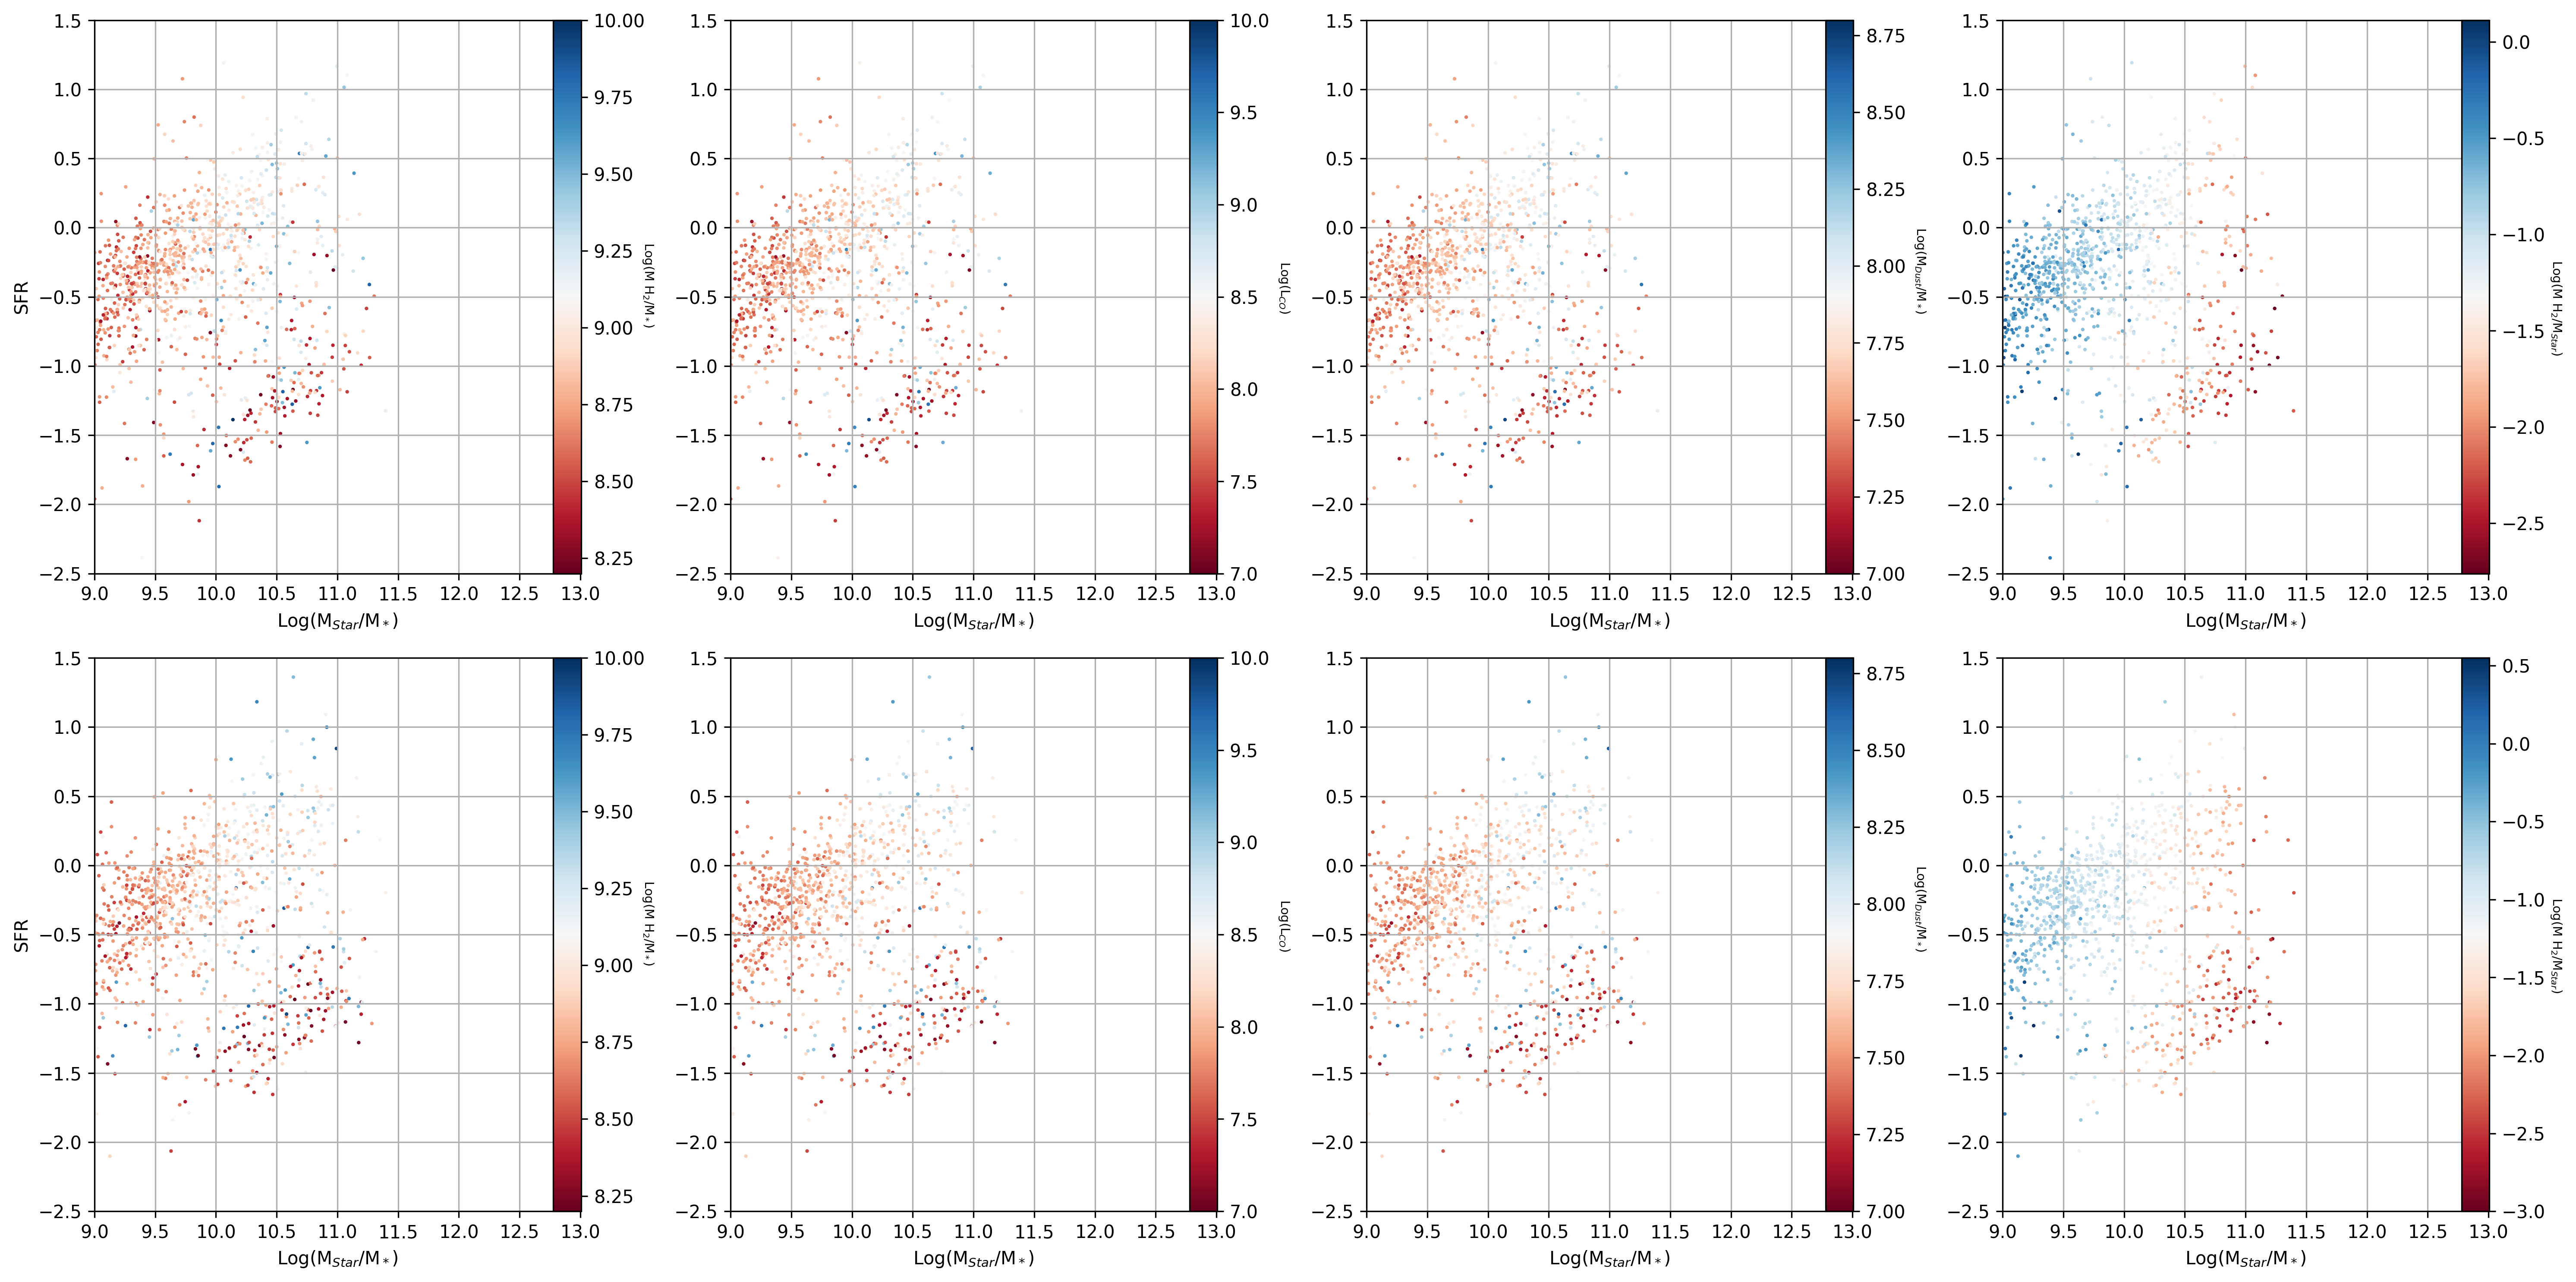

In [14]:
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = figure(num=None, figsize=(20,10), dpi=300, facecolor='w', edgecolor='k')

ylolim = -2.5
yhighlim=1.5

plt.subplot(2, 4, 1)

plt.scatter(hightmpStarmass,hightmpSFR,c=(hightmpMH2),s=1,cmap = "RdBu")
plt.grid()
plt.xlabel(StarMassLabel)
plt.axis("tight")
plt.ylabel(SFRLabel)
plt.colorbar(pad=-0.05,)
plt.clim(vmin=8.2,vmax=10)

plt.text(13.5,-.7, MH2Label, rotation = -90,size="x-small")
plt.xlim(9,13)
plt.tight_layout()
plt.ylim(ylolim,yhighlim)
plt.subplot(2, 4, 2)

plt.scatter(hightmpStarmass,hightmpSFR,c=hightmpLCO,s=1,cmap="RdBu")
plt.grid()
plt.xlabel(StarMassLabel)
# plt.ylabel(SFRLabel)
plt.axis("tight")
plt.colorbar(pad=-0.05,)
plt.text(13.5,-0.6, LCOLabel, rotation = -90,size="x-small")
plt.xlim(9,13)
plt.clim(vmin=7,vmax=10)
plt.tight_layout()
plt.ylim(ylolim,yhighlim)
plt.subplot(2, 4, 3)

plt.scatter(hightmpStarmass,hightmpSFR,c=hightmpMDust,s=1,cmap="RdBu") # colorize this by inclination!!
plt.grid()
plt.xlabel(StarMassLabel)
# plt.ylabel(SFRLabel)
plt.axis("tight")
plt.colorbar(pad=-0.05,)
plt.text(13.5,-0.6, MDustLabel, rotation = -90,size="x-small")
plt.xlim(9,13)
plt.clim(vmin=7,vmax=8.8)
plt.tight_layout()
plt.ylim(ylolim,yhighlim)
plt.subplot(2, 4, 4)

plt.scatter(hightmpStarmass,hightmpSFR,c=hightmpGasFrac,s=1,cmap="RdBu") # colorize this by inclination!!
plt.grid()
plt.xlabel(StarMassLabel)
# plt.ylabel(SFRLabel)
plt.axis("tight")
plt.colorbar(pad=-0.05,)
plt.text(13.5,-.9, "Log(M H$_2$/M$_{Star}$)", rotation = -90,size="x-small")
plt.xlim(9,13)
# plt.clim(vmin=-3,vmax=0.55)
# plt.clim(min(hightmpGasFrac),max(hightmpGasFrac))

plt.tight_layout()
plt.ylim(ylolim,yhighlim)

plt.subplot(2, 4, 5)

plt.scatter(lowtmpStarmass,lowtmpSFR,c=(lowtmpMH2),s=1,cmap = "RdBu")
plt.grid()
plt.xlabel(StarMassLabel)
plt.axis("tight")
plt.ylabel(SFRLabel)
plt.colorbar(pad=-0.05,)
plt.clim(vmin=8.2,vmax=10)
plt.text(13.5,-.7, MH2Label, rotation = -90,size="x-small")
plt.xlim(9,13)
plt.ylim(ylolim,yhighlim)

plt.subplot(2, 4, 6)

plt.scatter(lowtmpStarmass,lowtmpSFR,c=lowtmpLCO,s=1,cmap="RdBu")
plt.grid()
plt.xlabel(StarMassLabel)
# plt.ylabel(SFRLabel)
plt.axis("tight")
plt.colorbar(pad=-0.05,)
plt.text(13.5,-0.6, LCOLabel, rotation = -90,size="x-small")
plt.xlim(9,13)
plt.ylim(ylolim,yhighlim)
plt.clim(vmin=7,vmax=10)

plt.subplot(2, 4, 7)

plt.scatter(lowtmpStarmass,lowtmpSFR,c=lowtmpMDust,s=1,cmap="RdBu") 
plt.grid()
plt.xlabel(StarMassLabel)
# plt.ylabel(SFRLabel)
plt.axis("tight")
plt.colorbar(pad=-0.05,)
plt.text(13.5,-0.6, MDustLabel, rotation = -90,size="x-small")
plt.xlim(9,13)
plt.clim(vmin=7,vmax=8.8)
plt.ylim(ylolim,yhighlim)

plt.subplot(2, 4, 8)

plt.scatter(lowtmpStarmass,lowtmpSFR,c=lowtmpGasFrac,s=1,cmap="RdBu")
plt.grid()
plt.xlabel(StarMassLabel)
# plt.ylabel(SFRLabel)
plt.axis("tight")
plt.colorbar(pad=-0.05,)
plt.clim(vmin=-3,vmax=0.55)
plt.text(13.5,-.9, "Log(M H$_2$/M$_{Star}$)", rotation = -90,size="x-small")
plt.xlim(9,13)
plt.clim(vmin=-3,vmax=.55)
plt.ylim(ylolim,yhighlim)

plt.tight_layout()

plt.savefig("StackedInclination.png",dpi=300)

plt.show()

## Heatmap of residual xCold Data

##### Goal
To plot a heatmap of the residual gas fraction when comparing inferred MCMC with real results from xCold

In [8]:
xColdDF = pd.read_csv("xColdFilt.csv") # importing the xCold Set
xColdDF = xColdDF.drop(columns = ["Unnamed: 0"])
xColdDF = reducer2(xColdDF,xColdDF["LOGMH2"],0) # removing galaxies without molecular hydrogen data
xColdDF["LOG_SFR_BEST"] = np.log10(xColdDF["SFR_BEST"])
xColdDF["GasFrac"] = np.log10((10**(xColdDF["LOGMH2"]))/(10**(xColdDF["MASS"])))
print(xColdDF.columns.values)

['ID' 'SAMPLE' 'AGCNR' 'SDSS' 'OBJID' 'SPECOBJID' 'PLATEID' 'MJD'
 'FIBERID' 'RA' 'DEC' 'Z_SDSS' 'LUMDIST' 'INCL' 'NUVR_GEXT' 'D25_G'
 'R50_R' 'R50KPC' 'R50_Z' 'R50_NUV' 'R50_NUV_ERR' 'R50_SFR' 'R50_SFR_ERR'
 'MASS' 'MASS_ERR' 'MUST' 'CINDX' 'SFR_SDSS' 'SFR_SED' 'SFR_BEST'
 'SFR_ERR' 'SFR_CASE' 'SFR_IR' 'SFR_IR_ERR' 'SSFR' 'DELTAMS_P10'
 'DELTAMS_S16' 'DELTAMS_W12' 'DELTAMS_W14' 'D4000' 'N2HA' 'O3HB' 'BALMER'
 'BALMER_ERR' 'AGNCLASS' 'Z_PP04_N2' 'Z_PP04_O3N2' 'Z_MZR' 'Z_FIBER'
 'HISRC' 'ZHI' 'W50COR' 'LOGMHI' 'LOGMHIMS' 'HICONF' 'GROUPID'
 'ENVIRONMENT' 'NGROUP' 'LOGMHALO' 'LOGRNORM' 'FLAG_CO' 'XCO' 'XCO_G12'
 'XCO_A16' 'XCO_A16_ERR' 'ICO' 'ICO_ERR' 'ICO_COR' 'ICO_COR_ERR' 'F_RECOV'
 'LCO' 'LCO_ERR' 'LCO_COR' 'LCO_COR_ERR' 'RMS_CO' 'SN_CO' 'WCO' 'WCO_FLAG'
 'Z_CO' 'WCO_TFR' 'WCO_TFR_ERR' 'WCO_TFR_FLAG' 'LOGMH2' 'LOGMH2_ERR'
 'LIMLOGMH2' 'MH2_ERR' 'LOGMH2MS' 'LOGRMOL' 'FLAGRMOL' 'FLAG_CO21' 'ICO21'
 'ICO21_ERR' 'ICO21_COR' 'LCO21' 'LCO21_ERR' 'LCO21_COR' 'RMS_CO21'
 'SN_CO21' 'WCO21' 'W

#### Here's a nice plot

106092


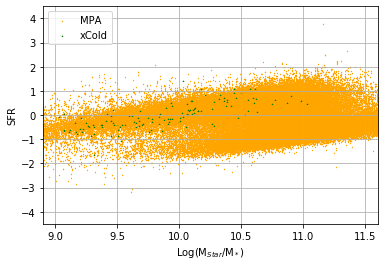

In [9]:
plt.scatter(MPAMaster["StarMass"],MPAMaster["SFR"],c="orange",s=.2,marker="d",label = "MPA")
plt.scatter(xColdDF["MASS"],xColdDF["LOG_SFR_BEST"],c="green",s=1,marker="1",label="xCold")
plt.xlabel(StarMassLabel)
plt.ylabel(SFRLabel)
plt.legend()
# plt.colorbar()
plt.xlim(8.9,11.6)
plt.ylim(-4.5,4.5)
plt.grid()

print(len(MPAMaster))

plt.show()

In [10]:
grids=30 # define however many grids you want for the mean colormap here

x = np.array(xColdDF["MASS"]) # define variables
y = np.array(xColdDF["LOG_SFR_BEST"])
z = np.array(xColdDF["GasFrac"])

In [11]:
def getMean(x,y,z):

    minx = min(x)
    maxx = max(x)
    miny = -10 # should b min(y)
    maxy = 10
    points_x = np.linspace(minx,maxx,num=grids)
    points_y = np.linspace(miny,maxx,num=grids)
    gridX,gridY = np.meshgrid(points_x,points_y)
    gridZ = np.zeros([len(gridX),len(gridX)])
    del_x = (maxx-minx)/(2*grids)
    del_y = (maxy-miny)/(2*grids)
    
    for i in range(len(points_x)): # double looping gridX
        for j in range(len(points_y)):
            sumlist=0
            countlist=0
            for g in range(len(x)):
                if x[g]>=(points_x[i]-del_x) and x[g]<=(points_x[i]+del_x) and y[g]>=(points_y[j]-del_y) and y[g]<=(points_y[j]+del_y):
                    sumlist+=z[i]
                    countlist+=1
            if sumlist!=0:
                gridZ[j][i] = sumlist/countlist
    return gridX,gridY,gridZ

In [12]:
gridXxCold,gridYxCold,gridZxCold = getMean(x,y,z)
gridXMPA,gridYMPA,gridZMPA = getMean(np.array(MPAMaster["StarMass"]),np.array(MPAMaster["SFR"]),np.array(MPAMaster["GasFrac"]))

difGrid = gridZxCold-gridZMPA

KeyError: 'GasFrac'

In [ ]:
# plt.figure(figsize=(6,6),dpi=300)
plt.scatter(gridXxCold,gridYxCold,c=difGrid,s=50,marker="s")
plt.colorbar()

plt.xlabel(StarMassLabel)
plt.ylabel(SFRLabel)

plt.scatter(np.array(MPAMaster["StarMass"]),np.array(MPAMaster["SFR"]),c="b",marker="x",s=.2,label="MPA")
plt.scatter(x,y,c="r",s=2,marker=".",label="xCold")
plt.legend()
plt.grid()

plt.ylim(-10,10)

plt.savefig("hmapSmassVSFRVGasFracDiff.png",dpi=300)

plt.show()